<a href="https://colab.research.google.com/github/sibhap/CSE_6250_Project/blob/master/KSI%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install stop-words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=0790b1c80423a4820a01ebc301794bd3b9a30f08cf7927652de2d76a3a53e011
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [3]:
%cd /content/gdrive/My Drive/CS6250

/content/gdrive/My Drive/CS6250


In [ ]:
!python preprocessing1.py

In [ ]:
!python preprocessing2.py

tcmalloc: large alloc 5134286848 bytes == 0x5c50a000 @  0x7ff2b05b7001 0x7ff2adf461af 0x7ff2adf9cc23 0x7ff2adf9da87 0x7ff2ae03f823 0x58f62c 0x510bf2 0x58fd37 0x510325 0x5b4ee6 0x58ff2e 0x510325 0x4bac0a 0x4d3249 0x5917ee 0x591ac9 0x539167 0x50cb08 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7ff2b01b2c87 0x5b636a
tcmalloc: large alloc 5134286848 bytes == 0x18f328000 @  0x7ff2b05b51e7 0x7ff2adf460ce 0x7ff2adfa0726 0x7ff2adfa0b09 0x7ff2adfa2620 0x7ff2adfa2d1b 0x7ff2ae043333 0x58f62c 0x510bf2 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7ff2b01b2c87 0x5b636a


In [ ]:
!python preprocessing3.py

tcmalloc: large alloc 5134286848 bytes == 0x1f1a2000 @  0x7f99eb4d81e7 0x7f99e8e290ce 0x7f99e8e80e57 0x7f99e8e81a6f 0x7f99e8f27c5d 0x58f795 0x510bf2 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x6005a3 0x607796 0x60785c 0x60a436 0x64db82 0x64dd2e 0x7f99eb0d5c87 0x5b636a
preprocessing3.py:98: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data=np.array(data)


In [ ]:
!pip install tensorflow

In [ ]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.models import Sequential
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers import Concatenate
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import regularizers
import joblib
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [5]:
label_to_ix=np.load('label_to_ix.npy', allow_pickle=True).item()
ix_to_label=np.load('ix_to_label.npy', allow_pickle=True)
training_data=np.load('training_data.npy', allow_pickle=True)
test_data=np.load('test_data.npy', allow_pickle=True)
val_data=np.load('val_data.npy', allow_pickle=True)
word_to_ix=np.load('word_to_ix.npy', allow_pickle=True).item()
ix_to_word=np.load('ix_to_word.npy', allow_pickle=True)
newwikivec=np.load('newwikivec.npy', allow_pickle=True)

# LSTM Base Model - Without wiki data

In [13]:
# Create the model:

EMBEDDING_SIZE = 100
hidden_dim=500
maxlen = 200
MAX_SEQ_LENGTH = 100
MAX_VOCAB = len(word_to_ix)
num_classes = len(label_to_ix)

def build_cnn_model(input_length, embedding_size, max_vocab, num_filters, filter_sizes, training_dropout_keep_prob, num_classes):
  model_input = Input(shape=input_length)
  z =  Embedding(max_vocab + 1, embedding_size,input_length=input_length, embeddings_regularizer=regularizers.l2(0.0001),name="embedding")(model_input)
  # Convolutional block
  conv_blocks = []
  for sz in filter_sizes:
      conv = Convolution1D(filters=num_filters,                         
                        kernel_size=sz,
                        padding="valid",
                        activation="relu",
                        strides=1)(z)
      window_pool_size =  input_length  - sz + 1 
      conv = MaxPooling1D(pool_size=window_pool_size)(conv)  
      conv = Flatten()(conv)
      conv_blocks.append(conv)
  #concatenate
  z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
  z = Dropout(training_dropout_keep_prob)(z)
  # z = Dense(hidden_dim, activation="relu")(z)
  model_output = Dense(num_classes, activation="sigmoid")(z)

  model = Model(model_input, model_output)
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  # print(model.summary())
  return model
def build_lstm_model(input_length, embedding_size, max_vocab, num_filters, filter_sizes, training_dropout_keep_prob, num_classes):
  model_input = Input(shape=input_length)
  model = keras.models.Sequential()
  model.add(Embedding(max_vocab + 1, embedding_size, input_length=input_length, embeddings_regularizer=regularizers.l2(0.0001),name="embedding"))
  model.add(layers.LSTM(64, dropout=0.1))
  model.add(layers.Dense(num_classes, activation="sigmoid"))
  model.summary()
  loss = keras.losses.BinaryCrossentropy(from_logits=False)
  optim = keras.optimizers.Adam(learning_rate=0.001)
  metrics = ["accuracy"]
  model.compile(loss=loss, optimizer=optim, metrics=metrics)  
  return model

In [14]:
# cnn_model = build_cnn_model(input_length=MAX_SEQ_LENGTH, embedding_size=EMBEDDING_SIZE, max_vocab = MAX_VOCAB, num_filters = 100, filter_sizes=[2,3,4,5],
#                              training_dropout_keep_prob=0.5, num_classes = num_classes)
# print(cnn_model.summary())
lstm_model = build_lstm_model(input_length=MAX_SEQ_LENGTH, embedding_size=EMBEDDING_SIZE, max_vocab = MAX_VOCAB, num_filters = 100, filter_sizes=[2,3,4,5],
                             training_dropout_keep_prob=0.5, num_classes = num_classes)
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          4796100   
                                                                 
 lstm_2 (LSTM)               (None, 64)                42240     
                                                                 
 dense_2 (Dense)             (None, 344)               22360     
                                                                 
Total params: 4,860,700
Trainable params: 4,860,700
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          4796100   
                                                                 
 lstm_2 (LSTM)        

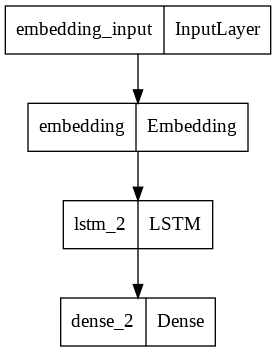

In [15]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(lstm_model,'lstm_base.png')
Image('lstm_base.png')

In [16]:
count = [len(x[0]) for x in training_data]

In [17]:
min(count), max(count), np.mean(count), np.median(count)

(36, 5285, 1023.7772870149578, 937.0)

In [18]:
def get_data(input_data):
  # training_data is of the form (list of list of words, notes, y )
  #training_data[0]
  #array([list(['admission', 'date', 'discharge', 'date', 'date', 
  #array([1., 1., 1., ..., 0., 0., 0.]),
       #list(['d_427', 'd_423', 'd_458', 'd_401', 'd_272', 'd_250', 'd_424'])],
  x_data =  [[word_to_ix[x] for x in record[0] if x in word_to_ix] for record in input_data]
  x_data = tf.keras.utils.pad_sequences(x_data, maxlen=MAX_SEQ_LENGTH, padding="post")
  y_data = [[label_to_ix[x] for x in record[2] if x in label_to_ix] for record in input_data]
  ylabel_count = np.array([len(item) for item in y_data])
  arg_zero = np.argwhere(ylabel_count == 0)
  y_data = [y_data[i] for i in range(len(y_data)) if i not in arg_zero]
  x_data = [x_data[i] for i in range(len(x_data)) if i not in arg_zero]
  x_data = np.array(x_data)
  for idx, item in enumerate(y_data):
    y = np.zeros(len(label_to_ix),)
    y[item] = 1
    y_data[idx] = y
  y_data = np.array(y_data)
  return x_data, y_data

In [19]:
train_x, train_y = get_data(training_data)

In [20]:
train_y.shape, train_x.shape
# ((34898, 344), (34898, 100))

((34898, 344), (34898, 100))

In [21]:
val_x, val_y = get_data(val_data)
test_x, test_y = get_data(test_data)

In [22]:
val_y.shape, val_x.shape, test_y.shape, test_x.shape

((5022, 344), (5022, 100), (9985, 344), (9985, 100))

In [23]:
def train_lstm_model(train_x, train_y, val_x, val_y, batch_size=50, epochs=20):
  tf.config.run_functions_eagerly(True) # https://stackoverflow.com/questions/58352326/running-the-tensorflow-2-0-code-gives-valueerror-tf-function-decorated-functio
  lstm_model.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=batch_size, epochs=epochs, verbose=2)
  # save model
  lstm_model.save('lstm_20_epochs.h5')

In [24]:
import os
path='lstm_20_epochs.h5'
isExist = os.path.exists(path)
isExist

False

In [25]:
from keras.models import load_model
if not isExist:
  train_lstm_model(train_x, train_y, val_x, val_y, batch_size=50, epochs=20)

model = load_model('lstm_20_epochs.h5')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
698/698 - 254s - loss: 0.0933 - accuracy: 0.0343 - val_loss: 0.0560 - val_accuracy: 0.0337 - 254s/epoch - 363ms/step
Epoch 2/20
698/698 - 251s - loss: 0.0566 - accuracy: 0.0359 - val_loss: 0.0557 - val_accuracy: 0.0337 - 251s/epoch - 360ms/step
Epoch 3/20
698/698 - 243s - loss: 0.0566 - accuracy: 0.0359 - val_loss: 0.0558 - val_accuracy: 0.0337 - 243s/epoch - 347ms/step
Epoch 4/20
698/698 - 249s - loss: 0.0566 - accuracy: 0.0359 - val_loss: 0.0557 - val_accuracy: 0.0337 - 249s/epoch - 357ms/step
Epoch 5/20
698/698 - 251s - loss: 0.0564 - accuracy: 0.0358 - val_loss: 0.0554 - val_accuracy: 0.0337 - 251s/epoch - 360ms/step
Epoch 6/20
698/698 - 242s - loss: 0.0560 - accuracy: 0.0363 - val_loss: 0.0551 - val_accuracy: 0.0337 - 242s/epoch - 346ms/step
Epoch 7/20
698/698 - 241s - loss: 0.0559 - accuracy: 0.0361 - val_loss: 0.0551 - val_accuracy: 0.0337 - 241s/epoch - 345ms/step
Epoch 8/20
698/698 - 241s - loss: 0.0558 - accuracy: 0.0363 - val_loss: 0.0551 - val_accuracy: 0.0337 - 

In [26]:
#prediction for training data
pred_train = model.predict(train_x, batch_size=50)
pred_train

698/698 [==============================] - 74s 105ms/step


array([[6.3325383e-02, 5.1359430e-02, 1.4788611e-02, ..., 1.7221306e-05,
        1.7390237e-05, 1.2239392e-05],
       [1.5321411e-01, 7.2472662e-02, 6.6479690e-02, ..., 3.5813078e-05,
        7.4460382e-05, 1.1525714e-04],
       [1.1186317e-01, 6.2642165e-02, 4.1533012e-02, ..., 3.6837137e-05,
        5.7538124e-05, 5.8692094e-05],
       ...,
       [1.5129659e-01, 7.9013862e-02, 3.7823983e-02, ..., 2.2268108e-05,
        3.3267104e-05, 5.2585790e-05],
       [1.5063724e-01, 5.6401730e-02, 3.7409935e-02, ..., 4.4204327e-05,
        6.1802530e-05, 3.6403475e-05],
       [1.2294548e-01, 7.3935173e-02, 3.4054458e-02, ..., 2.4212017e-05,
        3.4356908e-05, 4.1486492e-05]], dtype=float32)

In [27]:
#prediction for validation data
pred_val = model.predict(val_x, batch_size=100)
pred_val

51/51 [==============================] - 8s 152ms/step


array([[3.58067788e-02, 3.93832810e-02, 6.76699169e-03, ...,
        1.15273651e-05, 9.12230189e-06, 4.27317309e-06],
       [1.30691439e-01, 7.22649843e-02, 4.74191308e-02, ...,
        3.20769250e-05, 5.45916228e-05, 6.82814280e-05],
       [9.92466211e-02, 5.40403463e-02, 2.96169817e-02, ...,
        2.62037574e-05, 3.53248761e-05, 3.44598739e-05],
       ...,
       [4.26556282e-02, 2.31563505e-02, 1.19532002e-02, ...,
        4.54292713e-05, 4.63442811e-05, 6.27524742e-06],
       [1.77508906e-01, 8.24438557e-02, 6.36606067e-02, ...,
        2.95609843e-05, 5.61714696e-05, 1.01425467e-04],
       [1.18130155e-01, 7.00769946e-02, 3.84424143e-02, ...,
        2.97258794e-05, 4.46135491e-05, 4.86438403e-05]], dtype=float32)

In [28]:
val_y.shape, pred_val.shape

((5022, 344), (5022, 344))

In [29]:
from sklearn.metrics import f1_score, roc_auc_score
def get_f1_score(y_actual, pred_val):
  y_final = np.where(np.array(pred_val) > 0.005, 1, 0)
  f1score_macro = f1_score(np.array(y_actual), y_final, average="macro")
  print(f"f1score_macro = {f1score_macro}")
  f1score_micro = f1_score(np.array(y_actual), y_final, average="micro")
  print(f"f1score_micro = {f1score_micro}")
  return f1score_macro, f1score_micro


In [ ]:
# f1score_micro = f1_score(np.array(train_y), y_final, average="micro")
# f1score_micro

0.12242476441350231

In [30]:
#prediction for test data
pred_test = model.predict(test_x, batch_size=100)
pred_test

100/100 [==============================] - 16s 161ms/step


array([[1.65461928e-01, 7.60063604e-02, 4.62627709e-02, ...,
        2.60505476e-05, 4.18949603e-05, 6.67340209e-05],
       [1.26163423e-01, 6.21519946e-02, 3.95148844e-02, ...,
        3.05543435e-05, 4.60312513e-05, 5.44732065e-05],
       [3.37379277e-02, 3.63198780e-02, 6.03366829e-03, ...,
        1.43468333e-05, 1.08800405e-05, 3.38366385e-06],
       ...,
       [3.61754633e-02, 3.83890308e-02, 6.60831761e-03, ...,
        1.04840719e-05, 8.21175945e-06, 4.21703044e-06],
       [8.82292166e-02, 5.82469851e-02, 2.23451518e-02, ...,
        1.90827122e-05, 2.31694630e-05, 2.33415376e-05],
       [1.19323097e-01, 6.37281835e-02, 2.92641167e-02, ...,
        2.29354901e-05, 2.93504199e-05, 3.29376962e-05]], dtype=float32)

In [31]:
f1score_macro, f1score_micro = get_f1_score(val_y, pred_val)
f1score_macro, f1score_micro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


f1score_macro = 0.031046365427069483
f1score_micro = 0.09808448578341868


(0.031046365427069483, 0.09808448578341868)

In [32]:
f1score_test_macro, f1score_test_micro = get_f1_score(test_y, pred_test)
f1score_test_macro, f1score_test_micro

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


f1score_macro = 0.03189100053739335
f1score_micro = 0.09892578098710417


(0.03189100053739335, 0.09892578098710417)

In [33]:
y_final = np.where(np.array(pred_val) > 0.005, 1, 0)
print(len(np.unique(y_final)))
print(len(np.unique(val_y)))
# auc_macro = roc_auc_score(val_y, y_final, average="macro", multi_class="ovo")
# print(f"auc_macro = {auc_macro}")
auc_micro = roc_auc_score(val_y, y_final, average="micro")
print(f"auc_micro = {auc_micro}")

2
2
auc_micro = 0.833928807368601


In [34]:
y_final_test = np.where(np.array(pred_test) > 0.005, 1, 0)
print(len(np.unique(y_final_test)))
print(len(np.unique(test_y)))
# auc_macro = roc_auc_score(test_y, y_final_test, average="macro", multi_class="ovo")
# print(f"auc_macro = {auc_macro}")
auc_micro = roc_auc_score(test_y, y_final_test, average="micro")
print(f"auc_micro = {auc_micro}")

2
2
auc_micro = 0.8327903475643806


# Models from Original Paper

In [ ]:
!python KSI_CNN.py

KSI_CNN.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_CNN.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.447759546015512
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validati

In [ ]:
!python KSI_LSTM.py

KSI_LSTM.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_LSTM.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.4288319600440542
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
valid

In [ ]:
!python KSI_LSTMatt.py

KSI_LSTMatt.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_LSTMatt.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.3796880833045024
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [ ]:
!python KSI_CAML.py

KSI_CAML.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  new_data=np.array(new_data)
KSI_CAML.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  main_matrix = np.zeros((mybsize, numword), dtype= np.int)
start_training
0
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
validation top- 10 0.6044048484082241
1
XXXXXXXXXXXXXXXXXXXXXXXXXXXX
valid